In [50]:
# 라이브러리 설치
# uv add selenium
# 브러우저의 움직임을 제어하고 데이터를 가져올 수 있게 도와주는 도구

In [51]:
# 목표: 구글 플레이스토어에서 '배달의 민족' 검색한 후에 댓글을 수집

# 1. Chrome 창 켜기

In [ ]:
from selenium import webdriver

driver = webdriver.Chrome()  # 크롬 창 열기
driver.maximize_window()  # 창 최대화

# 2. 페이지 이동

In [53]:
url = "https://cafe.naver.com/f-e/cafes/25615725/menus/530?page=1"

driver.get(url)  # 페이지 이동

# 3. 돋보기 클릭하기

In [54]:
from selenium.webdriver.common.by import By

# 4. 검색어 입력

In [55]:
# keyword = "배달의 민족"

# input_box_selector = "#kO001e > header > nav > c-wiz > div > div > label > input"
# input_box = driver.find_element(By.CSS_SELECTOR, input_box_selector)
# input_box.send_keys(keyword)

# 5. 엔터 누르기

In [56]:
# from selenium.webdriver.common.keys import Keys

# input_box.send_keys(Keys.ENTER)

# 6. 배달의 민족 클릭

In [57]:
# detail_selector = "#yDmH0d > c-wiz:nth-child(7) > div > div > c-wiz > c-wiz:nth-child(1) > c-wiz > section > div > div > a"
# detail_area = driver.find_element(By.CSS_SELECTOR, detail_selector)
# # detail_area 클릭하려니 안됨. 다른 방법을 찾아보자.
# detail_url = detail_area.get_attribute("href")
# print(detail_url)

# driver.get(detail_url)

# 7. 마우스 아래로 스크롤

In [58]:
# driver.find_element(By.TAG_NAME, "body").send_keys(Keys.PAGE_DOWN)

# 8. 평점 및 리뷰 옆에 화살표 클릭

In [59]:
# more_selector = "#yDmH0d > c-wiz.SSPGKf.Czez9d > div > div > div:nth-child(1) > div > div.wkMJlb.YWi3ub > div > div.qZmL0 > div:nth-child(1) > c-wiz:nth-child(5) > section > header > div > div:nth-child(2) > button"
# more_btn = driver.find_element(By.CSS_SELECTOR, more_selector)
# more_btn.click()

# 9. 데이터 가져오기

## 1) 스크롤 아래로 내리기

In [60]:
# # 왜 내려야 하는가?
# # 스크롤을 맨 아래로 내렸을 때 그 다음 댓글이 추가되는 것을 확인함.
# import time

# # 키보드 스크롤 조작을 할 때에는 스크롤이 작동하는 영역에서 해야 한다.
# display_area_selector = "#yDmH0d > div.VfPpkd-Sx9Kwc.cC1eCc.UDxLd.PzCPDd.HQdjr.VfPpkd-Sx9Kwc-OWXEXe-FNFY6c > div.VfPpkd-wzTsW > div > div > div > div > div.fysCi.Vk3ZVd"
# display_area = driver.find_element(By.CSS_SELECTOR, display_area_selector)

# rep = 10
# for i in range(rep):
#     display_area.send_keys(Keys.END)
#     time.sleep(0.5)

## 2) 스크롤 맨 처음으로 올라가기

In [61]:
# display_area.send_keys(Keys.HOME)

## 3) 댓글 추출하기

In [62]:
import time

time.sleep(2)

In [63]:
row_selector = "#cafe_content > div.article-board > table > tbody:nth-child(5) > tr"
rows = driver.find_elements(By.CSS_SELECTOR, row_selector)
print(len(rows))

15


### (1) 리뷰 하나만 살펴보기

In [64]:
row = rows[0]
row

<selenium.webdriver.remote.webelement.WebElement (session="cf58288cc1227f361895c4761a2d977c", element="f.65E87AD01F69E9D7F3D85E4D1003E73A.d.67376C846584E559FD7CB2110CD5FED8.e.90")>

In [65]:
# 제목 찾기
title = row.find_element(By.CSS_SELECTOR, "a.article").text
print(title)

[사주질문]신년 운세 궁금합니다


In [66]:
# 작성자 찾기
nickname = row.find_element(By.CLASS_NAME, "nickname").text
print(nickname)

바라미


In [67]:
from datetime import datetime

# 등록일
enroll_date = row.find_element(By.CLASS_NAME, "type_date").text

# 1. 현재 날짜 가져오기 (2026.02.02. 양식)
today_str = datetime.now().strftime("%Y.%m.%d.")


# 2. 데이터 변환 로직
def fix_enroll_date(date_val):
    # ':'이 포함되어 있다면 시간 양식(00:00)으로 판단
    if ":" in str(date_val):
        return today_str
    return date_val


converted_date = fix_enroll_date(enroll_date)
print(converted_date)

2026.02.04.


In [68]:
# 좋아요수
like_number = int(row.find_element(By.CLASS_NAME, "type_likeCount").text)
print(like_number)

0


In [69]:
# 찾은 데이터 합치기
row_json = {
    "제목": title,
    "작성자": nickname,
    "등록일": converted_date,
    "좋아요수": like_number,
}
print(row_json)

{'제목': '[사주질문]신년 운세 궁금합니다', '작성자': '바라미', '등록일': '2026.02.04.', '좋아요수': 0}


### (2) 모든 리뷰 데이터 모으기(여기서부터 작업)

In [73]:
from datetime import datetime
import time

data_list = []
last_page = 55


# 데이터 변환 로직
def fix_enroll_date(date_val):
    # ':'이 포함되어 있다면 시간 양식(00:00)으로 판단
    if ":" in str(date_val):
        return today_str
    return date_val


print("데이터 수집을 시작합니다.")
for page in range(1, last_page + 1):
    url = f"https://cafe.naver.com/f-e/cafes/25615725/menus/530?page={page}"

    driver.get(url)
    time.sleep(2)
    if page == 1:
        row_selector = (
            "#cafe_content > div.article-board > table > tbody:nth-child(5) > tr"
        )
    else:
        row_selector = "#cafe_content > div.article-board > table > tbody > tr"
    rows = driver.find_elements(By.CSS_SELECTOR, row_selector)
    for idx, row in enumerate(rows):
        # 프린트 제어
        if idx % 5 == 0:
            print(f"{idx}번째 제목 행을 추출중입니다.....")

        title = row.find_element(By.CSS_SELECTOR, "a.article").text
        nickname = row.find_element(By.CLASS_NAME, "nickname").text

        # 등록일
        enroll_date = row.find_element(By.CLASS_NAME, "type_date").text

        # 1. 현재 날짜 가져오기 (2026.02.02. 양식)
        today_str = datetime.now().strftime("%Y.%m.%d.")

        converted_date = fix_enroll_date(enroll_date)
        like_number = int(row.find_element(By.CLASS_NAME, "type_likeCount").text)

        row_json = {
            "제목": title,
            "작성자": nickname,
            "등록일": converted_date,
            "좋아요수": like_number,
        }
        data_list.append(row_json)

데이터 수집을 시작합니다.
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번째 제목 행을 추출중입니다.....
0번째 제목 행을 추출중입니다.....
5번째 제목 행을 추출중입니다.....
10번

In [74]:
print(len(data_list))

816


In [75]:
data_list

[{'제목': '[사주질문]신년 운세 궁금합니다', '작성자': '바라미', '등록일': '2026.02.04.', '좋아요수': 0},
 {'제목': '[사주질문]무료사중요청 1년째집이 안팔려요',
  '작성자': '띠띠빵빵재',
  '등록일': '2026.02.03.',
  '좋아요수': 0},
 {'제목': '[사주질문]키우기 힘든 아이 사주 너무 궁금합니다..',
  '작성자': 'W430716',
  '등록일': '2026.02.02.',
  '좋아요수': 0},
 {'제목': '[사주질문]2028년에 대학합격운이 있을까요?',
  '작성자': '김태연',
  '등록일': '2026.02.02.',
  '좋아요수': 0},
 {'제목': '[사주질문]출산택일 선택 부탁드려요', '작성자': '감명', '등록일': '2026.02.02.', '좋아요수': 0},
 {'제목': '올해 어떤가요?', '작성자': 'dlwls80', '등록일': '2026.02.01.', '좋아요수': 0},
 {'제목': '재다신약 무관사주 남자는 사주적으로 어떻다고 보나요?',
  '작성자': '와수리 버스 터미널',
  '등록일': '2026.02.01.',
  '좋아요수': 0},
 {'제목': '답답합니다..', '작성자': 'Martina', '등록일': '2026.01.30.', '좋아요수': 0},
 {'제목': '[사주질문]결혼 할수있을까요', '작성자': '응가응', '등록일': '2026.01.26.', '좋아요수': 0},
 {'제목': '[사주질문]안녕하세요 선생님들(사주풀이)',
  '작성자': '민쥬공화국',
  '등록일': '2026.01.26.',
  '좋아요수': 0},
 {'제목': '[사주질문]축시가 아니라 자시라고 하네요(사실 정확은 안해요. 22일에 낳을줄 알았는데 23일에 낳았다….)',
  '작성자': '워플현',
  '등록일': '2026.01.24.',
  '좋아요수': 0},
 {'제목': '대운이 잘흐르는 사주인가요???',

## 4) 데이터프레임 만들기

In [76]:
import pandas as pd

df = pd.DataFrame(data_list)
df.head()

,제목,작성자,등록일,좋아요수
0,[사주질문]신년 운세 궁금합니다,바라미,2026.02.04.,0
1,[사주질문]무료사중요청 1년째집이 안팔려요,띠띠빵빵재,2026.02.03.,0
2,[사주질문]키우기 힘든 아이 사주 너무 궁금합니다..,W430716,2026.02.02.,0
3,[사주질문]2028년에 대학합격운이 있을까요?,김태연,2026.02.02.,0
4,[사주질문]출산택일 선택 부탁드려요,감명,2026.02.02.,0


In [77]:
df.to_csv("./data/20260204_사주풀이카페_고민_질문 조언하기-제목과 좋아요수만.csv")

In [78]:
from konlpy.tag import Okt

okt = Okt()

In [86]:
import re, emoji


def keep_text_and_emoji(sent):
    # 기본 텍스트 정규식으로 필터링
    clean = re.sub("[^0-9a-zA-Z가-힣\s]", "", sent)
    # 이모지는 따로 추출해서 붙여줌
    emojis = "".join(ch for ch in sent if ch in emoji.EMOJI_DATA)
    return clean + emojis


def get_word_list(df):
    # 0. 빈 리스트를 만든다. word_list, stopwords
    word_list = []
    stopwords = ["사주질문", "질문", "사주"]

    # 1. 데이터프레임에서 text 값을 하나씩 뽑는다. -> 문장 sent
    for sent in df["제목"]:
        # 2. sent에서 필요없는 문자(특수문자, 이모지 등)를 없앤다. (패턴: [^0-9a-zA-Z가-힣\s])
        clean_sent = keep_text_and_emoji(sent)
        # 3. 형태소 분석기로 문장을 단어 리스트로 뽑는다.(조건: Noun, 단어길이가 1보다 큰것, stopwords에 없는것) -> result
        ## 3-1. (단어, 품사) 쌍의 리스트로 결과를 출력한다.
        result = okt.pos(clean_sent)
        ## 3-2. 하나씩 뽑아서 품사가 Noun인지 확인한다.(반복)
        sub_list = []
        for res in result:
            word = res[0]
            pos = res[1]
            ## 3-3. word가 stopwords에 있으면 건너뛴다.
            if word in stopwords:
                continue
            ## 3-4. 품사가 Noun이고 word 길이가 1보다 큰 것을 sub list에 담는다.
            if pos == "Noun" and len(word) > 1:
                sub_list.append(word)
        print(sub_list)
        # 4. word_list에 조건에 따라 추출한 result 요소들을 추가한다.
        word_list.extend(sub_list)
        # print(f"{sent[:40]}")
        # print(f"{clean_sent[:40]}")
        # print(result)
        print("=" * 100)
    return word_list

In [87]:
word_list = get_word_list(df)

['신년', '운세']
['무료', '사중', '요청']
['아이']
['대학', '합격']
['출산', '택일', '선택']
['올해', '가요']
['신약', '무관', '남자', '보나']
[]
['결혼']
['선생님', '풀이']
['축시', '자시', '사실', '정확', '안해']
['대운']
['문제']
['진짜', '영험', '선생님']
['외로움', '해결']
[]
['자녀', '점사']
['무료', '합격']
['음력', '아들', '시험', '운좀']
['내년', '직장']
['음식물', '처리기', '스트레스', '분리수거', '경험']
['타로', '타로', '결과', '계속']
['오행', '기운', '가장']
['남자']
['기운']
['현실']
['이사']
['인생', '흐름', '세력', '첨부']
['이혼', '혼자']
['대운', '흐름', '분석']
['임신']
['경찰', '승진']
['한국', '화가', '김현정', '빈티', '매력', '작품', '소개']
['정도', '재물', '금전', '결과', '얼마', '정도']
['철학']
['복음', '세운', '보신']
['어제', '시간']
['문제', '출산', '택일']
[]
['전화']
['사이트', '세력']
['시기']
['서비스', '개발', '한번', '테스트']
['약대', '합격']
['타로', '타로']
[]
['아래', '시간']
['시간']
['용신']
['삼재']
['요새']
['재회', '추천']
['진로', '고민', '조언']
['아이', '본인', '공부', '할머니', '저주', '생각']
['이사']
['남편', '요즘']
['수능', '약대', '합격']
['진로', '고민']
['우울증']
['용신']
['저희', '부부', '아기', '언제']
['풀이', '해석']
['개념', '사람']
['전남친', '며칠', '불안', '상담', '정리']
['기타', '혹시']
['혹시', '철학', '사람']
['먹튀']
['남자', '갑

In [88]:
from collections import Counter

counter = Counter(word_list)

In [89]:
len(word_list)

1894

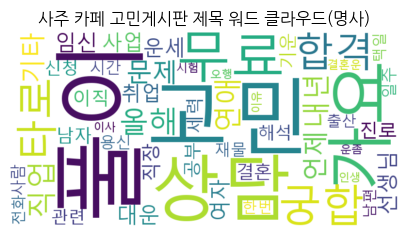

In [91]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import koreanize_matplotlib

wc = WordCloud(
    font_path="C:\Windows\Fonts\malgun.ttf",  # "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    background_color="white",
    width=800,
    height=400,
)

wc.generate_from_frequencies(dict(counter.most_common(50)))

plt.figure(figsize=(5, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("사주 카페 고민게시판 제목 워드 클라우드(명사)", fontsize=12)
plt.show()